In [1]:
import matplotlib.pyplot as plt
import geoopt
import torch
import itertools
import torch.nn as nn
import numpy as np
import tqdm
import os, sys, inspect
import scipy
import scipy.sparse as sp
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import geooptplus
from geoopt import ManifoldParameter, ManifoldTensor
from visualutil import add_geodesic_grid
from frechetmean import frechet_mean
from frechetmean import Poincare as PoincareFrechet

plt.rcParams["font.family"] = "serif"

In [2]:
ball = geooptplus.PoincareBall(c = 1)
n = 20
dim = 5
r1 = -1.5
r2 = 1.5

In [3]:
def cal_geodesic(man, x, y, t):
    res = man.mobius_add(-x, y)
    res = man.mobius_scalar_mul(torch.FloatTensor([t]), res)
    res = man.mobius_add(x, res)
    return res

def plot_geodesic(man, x, y):
    ts = np.arange(0, 1, 0.01)
    list_geopoint = []
    for t in ts:
        geopoint = cal_geodesic(man, x, y, t).numpy()
        list_geopoint.append(geopoint)
    list_geopoint = np.array(list_geopoint)
    return list_geopoint

def plot_poincare_mean_mm(x1, support = None, save_name = None):
    plt.figure(figsize=(3, 3))
    circle = plt.Circle((0, 0), 1, fill=False, color="b")
    add_geodesic_grid(plt.gca(), ball, 0.5)
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect("equal")

    if support is not None:
        for i in range(x1.shape[0]):
            geodesics = plot_geodesic(ball, x1[i], support[0])
            for j in range(geodesics.shape[0] - 1):
                xpoint = np.array([geodesics[j, 0], geodesics[j+1, 0]])
                ypoint = np.array([geodesics[j, 1], geodesics[j+1, 1]])
                label_line = None
                if i == 0 and j == 0: 
                    label_line = 'geodesics'
                plt.plot(xpoint, ypoint, color = 'g', alpha = 0.3, label = label_line, zorder=1)

    plt.scatter(x1[:,0], x1[:,1], c='r', alpha=1, cmap="rainbow", label = 'input', zorder=2)
    if support is not None:
        plt.scatter(support[:,0], support[:,1], c='b', alpha=1, cmap="rainbow", label = 'midpoint', zorder=2)
    # plt.axis('off')
    # plt.tight_layout()
    # plt.legend(loc='upper right')
    if save_name is not None:
        plt.savefig("./midpoints/{}.pdf".format(save_name), dpi=200, format="pdf")
    plt.show()

torch.Size([20, 5])
(True, None)


/tmp/ipykernel_714662/3764668538.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1[:,0], x1[:,1], c='r', alpha=1, cmap="rainbow", label = 'input', zorder=2)


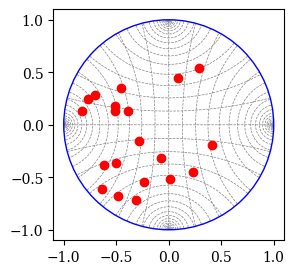

In [4]:
x1 = torch.FloatTensor(n, dim).uniform_(r1, 1)
x1 = ball.expmap0(x1).to(torch.double)
print(x1.shape)
print(ball._check_point_on_manifold(x1))
plot_poincare_mean_mm(x1)

In [5]:
curvature = ball.k
w = torch.rand((1 , x1.shape[0])).double()
w = w / w.sum()
print(w)

tensor([[0.0287, 0.0016, 0.0237, 0.0825, 0.0486, 0.0515, 0.0036, 0.0482, 0.0525,
         0.0784, 0.0128, 0.0723, 0.0986, 0.0870, 0.0468, 0.0274, 0.0516, 0.0816,
         0.0730, 0.0296]], dtype=torch.float64)


In [6]:
x1_tan = ball.logmap0(x1)
x1_tan_mean = w @ x1_tan
# x1_tan_mean = x1_tan.mean(dim=0)
support_tangential = ball.expmap0(x1_tan_mean)
print(support_tangential)
print(ball._check_point_on_manifold(support_tangential))

tensor([[-0.5477, -0.1951, -0.4143, -0.1980, -0.1031]], dtype=torch.float64)
(True, None)


In [7]:
curvature = ball.k
support_frechet = frechet_mean(x1, PoincareFrechet(K = curvature), w=w)
print(support_frechet)
print(ball._check_point_on_manifold(support_frechet))

tensor([[-0.2170, -0.0646, -0.1789, -0.0914, -0.0456]], dtype=torch.float64)
(True, None)


In [8]:
support_poincare_midpoint = ball.weighted_midpoint_bmm(x1, weights=w)
# support_poincare_midpoint = ball.weighted_midpoint(x1)
print(support_poincare_midpoint.reshape([1,-1]))
print(ball._check_point_on_manifold(support_poincare_midpoint))

tensor([[-0.2109, -0.0669, -0.2073, -0.1300, -0.0871]], dtype=torch.float64)
(True, None)


/tmp/ipykernel_714662/3764668538.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1[:,0], x1[:,1], c='r', alpha=1, cmap="rainbow", label = 'input', zorder=2)
/tmp/ipykernel_714662/3764668538.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support[:,0], support[:,1], c='b', alpha=1, cmap="rainbow", label = 'midpoint', zorder=2)


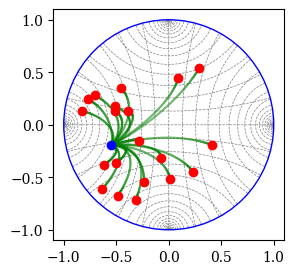

In [9]:
# slow and inaccurate
plot_poincare_mean_mm(x1, support_tangential.reshape([1,-1]))

/tmp/ipykernel_714662/3764668538.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1[:,0], x1[:,1], c='r', alpha=1, cmap="rainbow", label = 'input', zorder=2)
/tmp/ipykernel_714662/3764668538.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support[:,0], support[:,1], c='b', alpha=1, cmap="rainbow", label = 'midpoint', zorder=2)


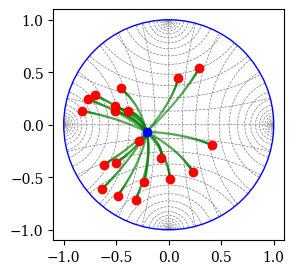

In [10]:
# trade off
plot_poincare_mean_mm(x1, support_poincare_midpoint.reshape([1,-1]))

/tmp/ipykernel_714662/3764668538.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1[:,0], x1[:,1], c='r', alpha=1, cmap="rainbow", label = 'input', zorder=2)
/tmp/ipykernel_714662/3764668538.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support[:,0], support[:,1], c='b', alpha=1, cmap="rainbow", label = 'midpoint', zorder=2)


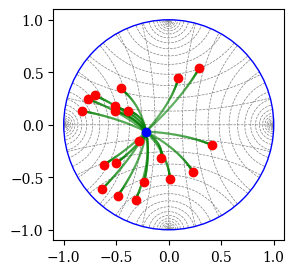

In [11]:
# the most accurate
plot_poincare_mean_mm(x1, support_frechet.reshape([1,-1]))